In [3]:
import findspark
findspark.init()

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.functions import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark import pandas

spark = SparkSession.builder.appName("MyApp").getOrCreate()

cores = spark._jsc.sc().getExecutorMemoryStatus().keySet().size()
print("You are working with", cores, "core(s)")
spark

You are working with 1 core(s)


In [4]:
df = spark.read.csv('CardioGoodFitness.csv',inferSchema=True, header=True)

df.printSchema()


root
 |-- Product: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Education: integer (nullable = true)
 |-- MaritalStatus: string (nullable = true)
 |-- Usage: integer (nullable = true)
 |-- Fitness: integer (nullable = true)
 |-- Income: integer (nullable = true)
 |-- Miles: integer (nullable = true)



In [5]:
df.limit(5).show()

+-------+---+------+---------+-------------+-----+-------+------+-----+
|Product|Age|Gender|Education|MaritalStatus|Usage|Fitness|Income|Miles|
+-------+---+------+---------+-------------+-----+-------+------+-----+
|  TM195| 18|  Male|       14|       Single|    3|      4| 29562|  112|
|  TM195| 19|  Male|       15|       Single|    2|      3| 31836|   75|
|  TM195| 19|Female|       14|    Partnered|    4|      3| 30699|   66|
|  TM195| 19|  Male|       12|       Single|    3|      3| 32973|   85|
|  TM195| 20|  Male|       13|    Partnered|    4|      2| 35247|   47|
+-------+---+------+---------+-------------+-----+-------+------+-----+



In [6]:
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+-------+---+------+---------+-------------+-----+-------+------+-----+
|Product|Age|Gender|Education|MaritalStatus|Usage|Fitness|Income|Miles|
+-------+---+------+---------+-------------+-----+-------+------+-----+
|      0|  0|     0|        0|            0|    0|      0|     0|    0|
+-------+---+------+---------+-------------+-----+-------+------+-----+



In [7]:
df.groupBy(df.columns).count().filter(col("count") > 1).show()

+-------+---+------+---------+-------------+-----+-------+------+-----+-----+
|Product|Age|Gender|Education|MaritalStatus|Usage|Fitness|Income|Miles|count|
+-------+---+------+---------+-------------+-----+-------+------+-----+-----+
+-------+---+------+---------+-------------+-----+-------+------+-----+-----+



In [8]:
df.summary().show()

+-------+-------+------------------+------+------------------+-------------+------------------+------------------+-----------------+------------------+
|summary|Product|               Age|Gender|         Education|MaritalStatus|             Usage|           Fitness|           Income|             Miles|
+-------+-------+------------------+------+------------------+-------------+------------------+------------------+-----------------+------------------+
|  count|    180|               180|   180|               180|          180|               180|               180|              180|               180|
|   mean|   null|28.788888888888888|  null|15.572222222222223|         null|3.4555555555555557| 3.311111111111111|53719.57777777778|103.19444444444444|
| stddev|   null| 6.943498135399797|  null|1.6170548978065555|         null|1.0847970343962434|0.9588685656193114|16506.68422623862| 51.86360466180932|
|    min|  TM195|                18|Female|                12|    Partnered|            

[Row(Product='TM195', count=80), Row(Product='TM498', count=60), Row(Product='TM798', count=40)]


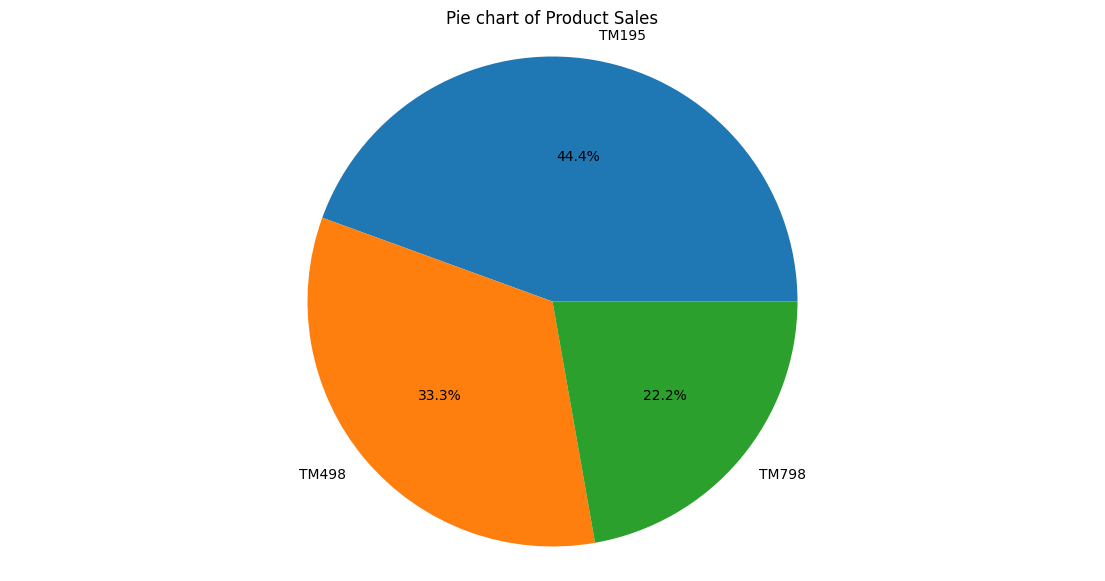

In [9]:
#GRAPH1
from pyspark.sql.functions import desc

# Tính số lượng sản phẩm
product_counts = df.groupBy("Product").count().orderBy(desc("count")).collect()
print(product_counts)

products = [product for product, count in product_counts]
counts = [count for product, count in product_counts]
plt.figure(figsize=(14, 7))
plt.pie(counts, labels=products, autopct='%1.1f%%')
plt.title("Pie chart of Product Sales")
plt.axis('equal')
plt.show()
# # Chuyển đổi kết quả sang Pandas DataFrame
# product_counts_pd = product_counts.toPandas()

# # Vẽ biểu đồ tròn
# plt.figure(figsize=(14, 7))
# plt.pie(product_counts_pd["count"], labels=product_counts_pd["Product"], autopct='%1.1f%%', startangle=90)
# plt.title("Pie chart of Product Sales")
# plt.axis('equal')
# plt.show()


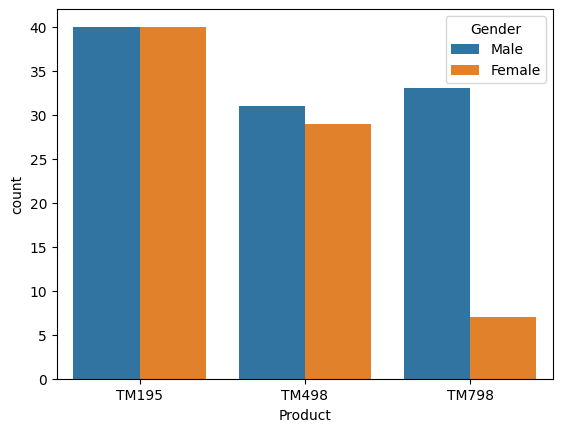

In [10]:
#GRAPH2
import seaborn as sns
# Vẽ biểu đồ đếm (countplot)
sns.countplot(x="Product", hue="Gender", data=df.toPandas())
plt.show()


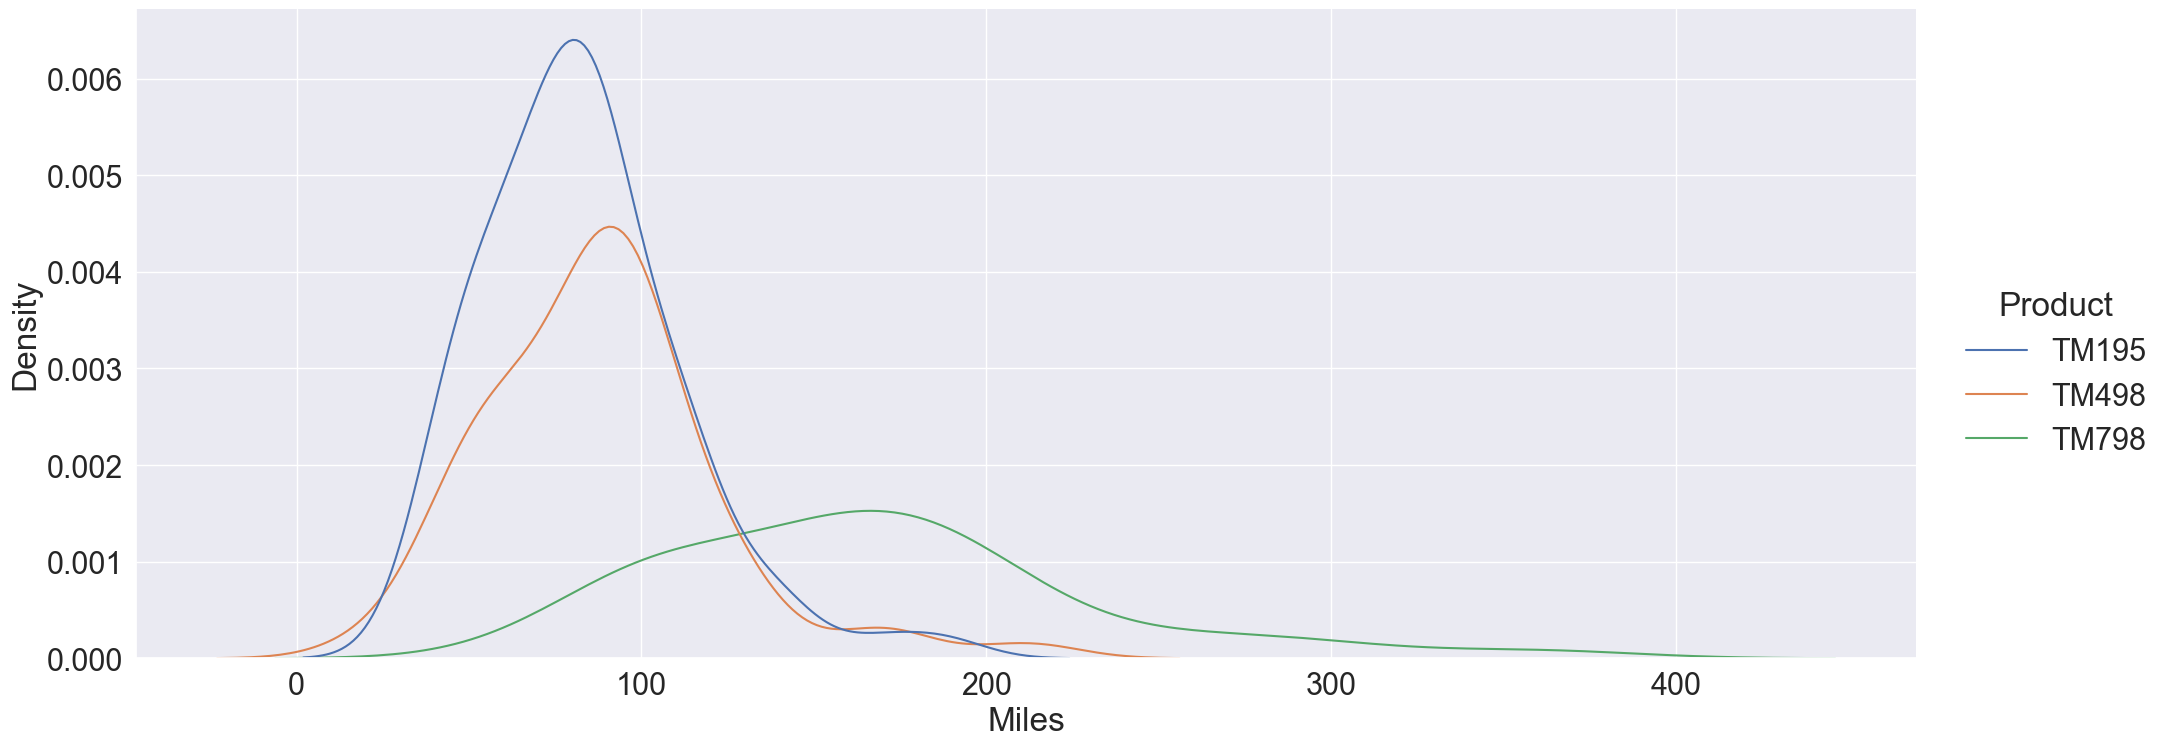

In [11]:
#GRAPH3

# Cài đặt font size của Seaborn
sns.set(font_scale=2)

# Vẽ biểu đồ KDE (Kernel Density Estimate)
sns.displot(data=df.toPandas(), x="Miles", hue="Product", kind='kde', height=8, aspect=2.5)
plt.show()


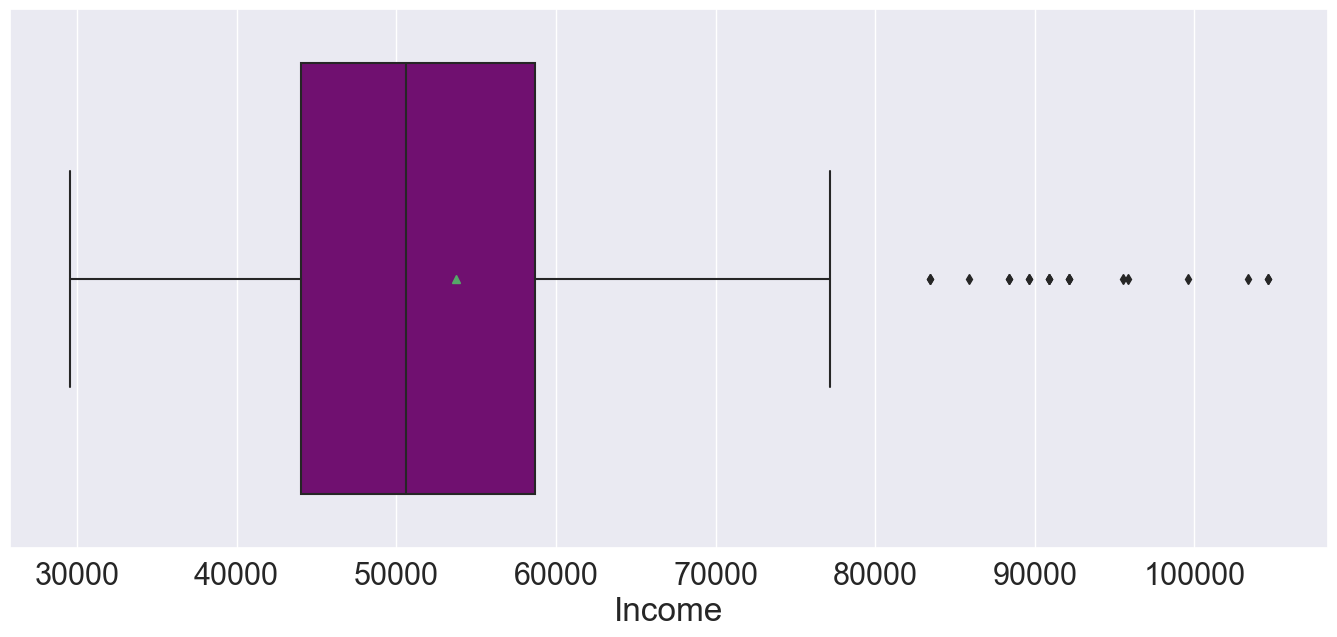

In [12]:
#GRAPH4
def dist_box_violin(data):
    Name = data.name.upper()
    fig=plt.subplots(1, figsize=(17, 7))
    sns.boxplot(x=data,showmeans=True, orient='h',color="purple")

dist_box_violin(df.toPandas().Income)


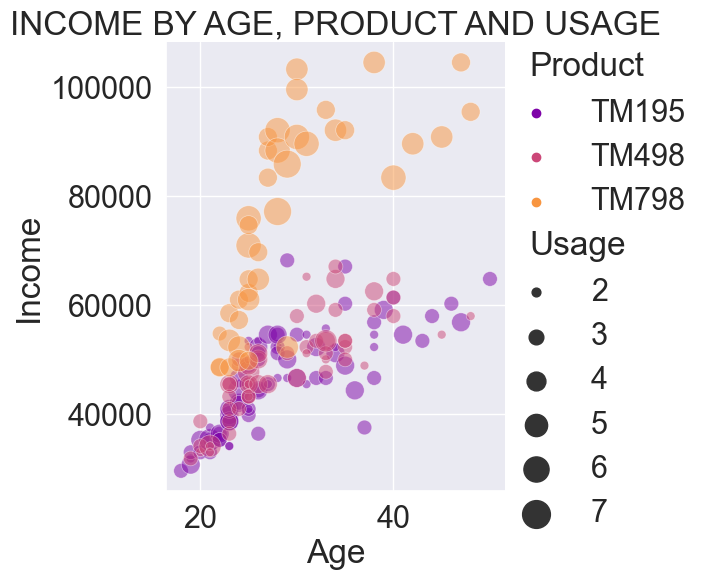

In [13]:

# Vẽ biểu đồ scatter plot
sns.relplot(x="Age", y="Income", hue="Product", size="Usage",
            sizes=(40, 400), alpha=.5, palette="plasma",
            height=6, data=df.toPandas())
plt.title('INCOME BY AGE, PRODUCT AND USAGE')
plt.show()


In [14]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

# convert to vector column first
vector_col = "corr_features"
cols = [col for col in df.columns if col not in ["Product", "Gender", "MaritalStatus", "Cardio"]]
assembler = VectorAssembler(inputCols=cols, outputCol=vector_col)

df_vector = assembler.transform(df).select(vector_col)
matrix = Correlation.corr(df_vector, vector_col)

# Extract the correlation matrix as a PySpark DataFrame
corr_df = matrix.collect()[0]["pearson({})".format("corr_features")].values.reshape(-1, len(df.columns)-3)

corr_pd = pd.DataFrame(corr_df, columns=cols, index=cols)
display(corr_pd)

,Age,Education,Usage,Fitness,Income,Miles
Age,1.000000,0.280496,0.015064,0.061105,0.513414,0.036618
Education,0.280496,1.000000,0.395155,0.410581,0.625827,0.307284
Usage,0.015064,0.395155,1.000000,0.668606,0.519537,0.759130
Fitness,0.061105,0.410581,0.668606,1.000000,0.535005,0.785702
Income,0.513414,0.625827,0.519537,0.535005,1.000000,0.543473
Miles,0.036618,0.307284,0.759130,0.785702,0.543473,1.000000


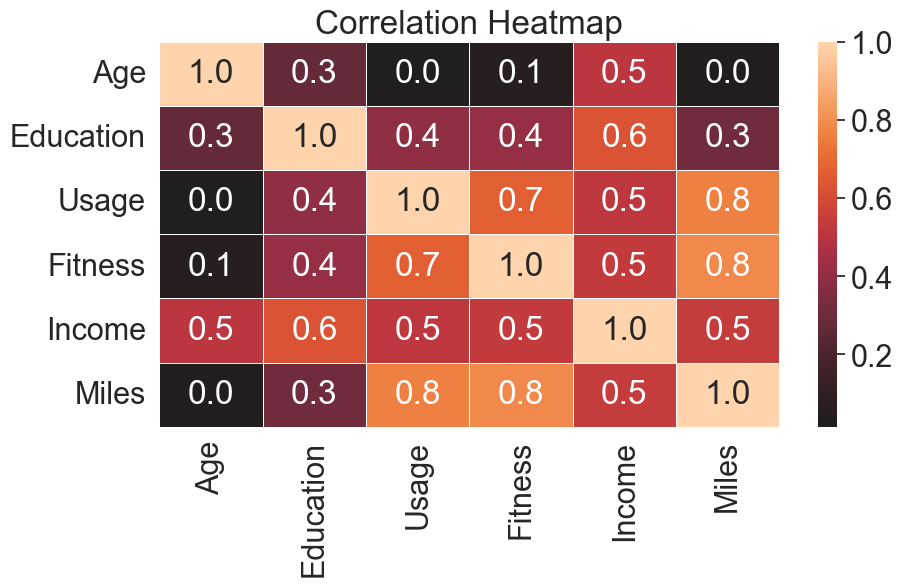

In [15]:

# Create a heatmap from the correlation table
plt.figure(figsize=(10, 5))
sns.heatmap(corr_pd, annot=True, linewidths=.5, fmt= '.1f', center=0)
plt.title('Correlation Heatmap')
plt.show()


In [53]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

X=df['Usage','Fitness'].collect()
y=df.select(df.Miles).collect()


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=0)

In [54]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_test,y_test)
lr.score(X_test,y_test)


0.7670482252399948

In [30]:
 # Logistic Regression
model=LogisticRegression()

model.fit(X_train,y_train)

y_pred=model.predict(X_test)
print(y_pred)

from sklearn.metrics import accuracy_score
k=accuracy_score(y_test,y_pred)
print('The accuracy is ',k)

[ 47  85  85  85  85  85  47  85 200  85  85  85 200  85  85  47 200 200
  85  85 200  85  85  94  85 200  85 200 200 200  85  85  85  85  85 200
  47  85  85 200  94  85  85  85  85  85  47  85  85 200  85  47 200  85]
The accuracy is  0.2222222222222222


c:\Users\phuch\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\phuch\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [31]:
# Decision Tree classifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

dtree = DecisionTreeClassifier()
dtree.fit(X_train,y_train)
predictions = dtree.predict(X_test)
print("The accuracy of Decision Tree is:", metrics.accuracy_score(predictions, y_test))

The accuracy of Decision Tree is: 0.18518518518518517
